In [24]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
import matplotlib.pyplot as plt
import os

raw_US = pd.read_csv('https://raw.githubusercontent.com/nytimes/covid-19-data/master/us.csv', 
                     index_col = 'date',
                     parse_dates = True).sort_index()
raw_states = pd.read_csv('https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-states.csv',
                     index_col = 'date',
                     parse_dates = True).sort_index()
raw_US.head()

,cases,deaths
date,,
2020-01-21,1,0
2020-01-22,1,0
2020-01-23,1,0
2020-01-24,2,0
2020-01-25,3,0


In [2]:
raw_states.head()

,state,fips,cases,deaths
date,,,,
2020-01-21,Washington,53,1,0
2020-01-22,Washington,53,1,0
2020-01-23,Washington,53,1,0
2020-01-24,Illinois,17,1,0
2020-01-24,Washington,53,1,0


/Users/vaibhavdwivedi/anaconda3/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


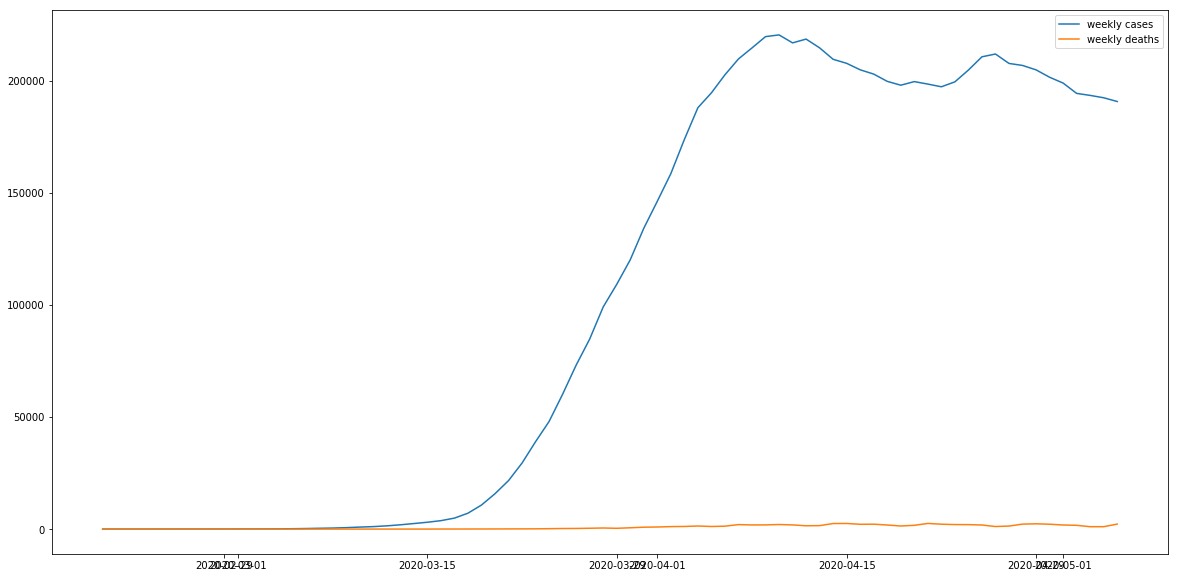

In [3]:
plt.figure(figsize = (20,10))
plt.plot(raw_US.cases.diff(7)[30:], label = "weekly cases" )
plt.plot(raw_US.deaths.diff()[30:], label = "weekly deaths")
plt.legend()

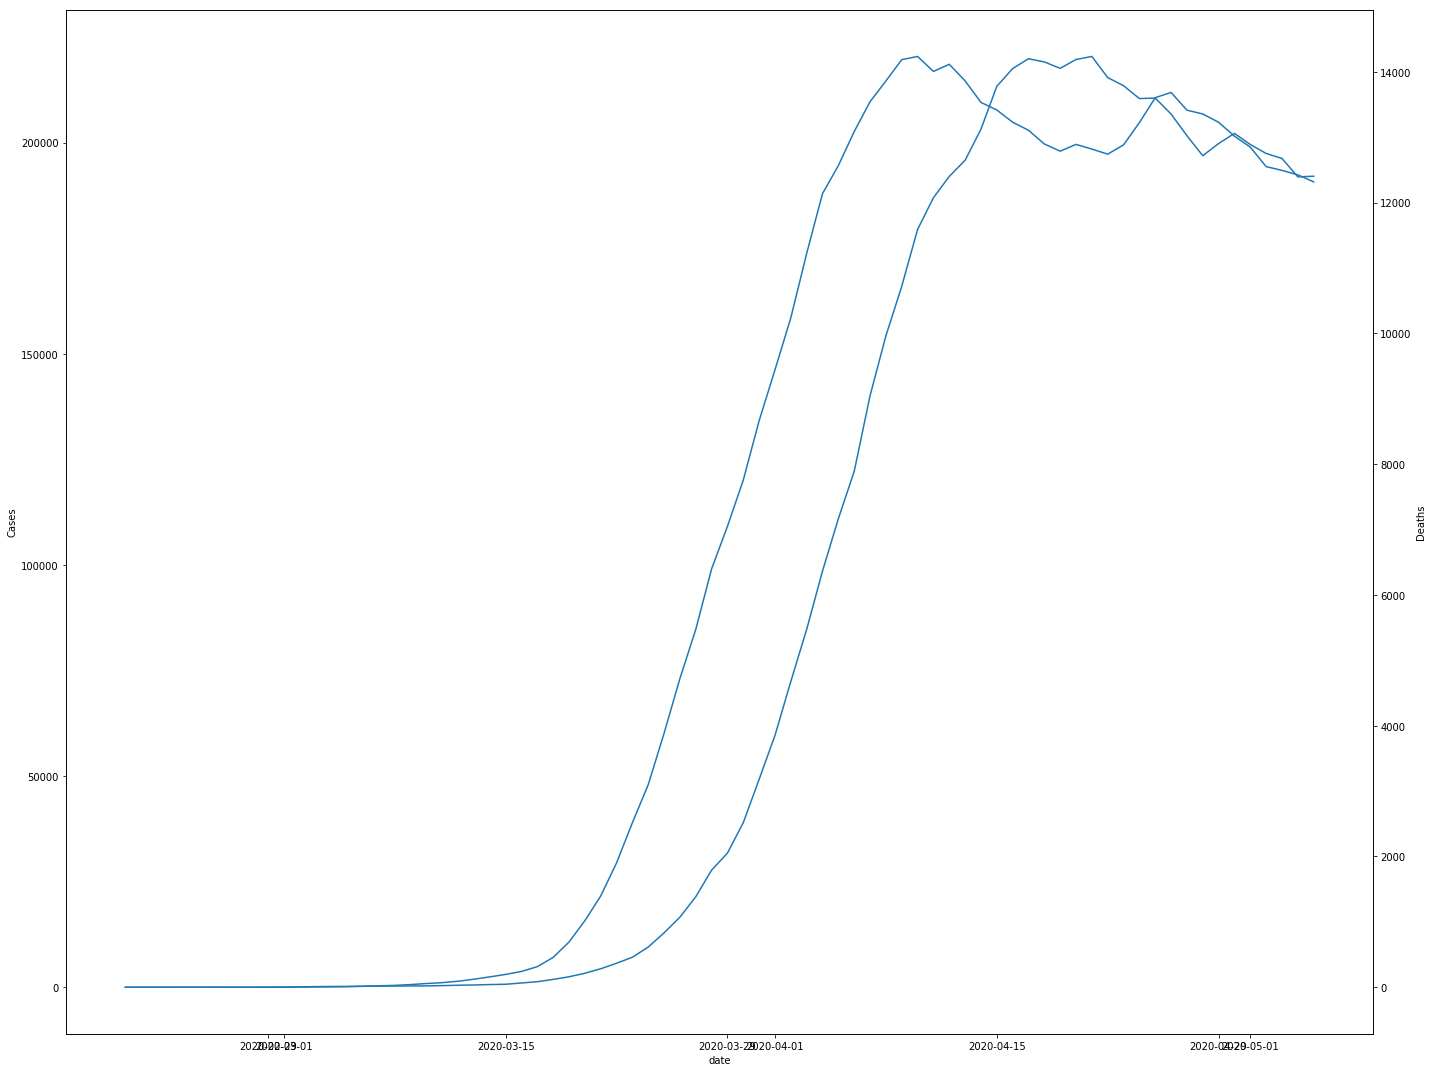

In [54]:
t = raw_US.index.to_list()[30:]
data1 = raw_US.cases.diff(7)[30:]
data2 = raw_US.deaths.diff(7)[30:]

fig, ax1 = plt.subplots( figsize=(20,15) )

#color = 'tab:red'
ax1.set_xlabel('date')
#ax1.set_ylabel('Cases', color=color)
ax1.set_ylabel('Cases')
#ax1.plot(t, data1, color=color)
ax1.plot(t, data1)
#ax1.tick_params(axis='y', labelcolor=color)
ax1.tick_params(axis='y')
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

#color = 'tab:blue'
#ax2.set_ylabel('Deaths', color=color)  # we already handled the x-label with ax1
ax2.set_ylabel('Deaths')  # we already handled the x-label with ax1
#ax2.plot(t, data2, color=color)
ax2.plot(t, data2)
#ax2.tick_params(axis='y', labelcolor=color)
ax2.tick_params(axis='y')

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

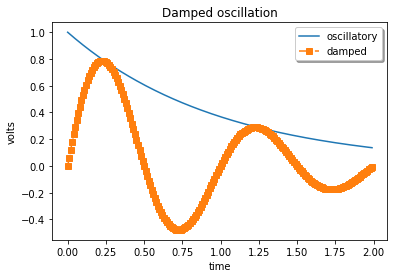